In [74]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 28*28 # 784
hidden1_size = 500 #
hidden2_size = 500 # 
num_epochs = 6 # number of times the algorithm is ran on the entire dataset

num_classes = 10 # 0 - 9
batch_size = 100
learning_rate = 0.001

SEED = 1234

num_misclassified_to_show = 5

In [76]:
torch.manual_seed(SEED)
np.random.seed(SEED * 2)
random.seed(SEED * 3)

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['lines.linewidth'] = 3

In [77]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(
	root='./data/',
	train=True,
	transform=transforms.ToTensor(),
	download=True
)

test_dataset = torchvision.datasets.MNIST(
	root='./data/',
	train=False,
	transform=transforms.ToTensor()
)

# Data loader
train_loader = torch.utils.data.DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True
)

test_loader = torch.utils.data.DataLoader(
	dataset=test_dataset,
	batch_size=batch_size,
	shuffle=False
)

In [78]:
# getting first batch of images and labels
# images, labels = next(iter(train_loader))

In [79]:
# fig, axs = plt.subplots(2, 5)
# for ii in range(2):
# 	for jj in range(5):
# 		idx = 5 * ii + jj
# 		axs[ii, jj].imshow(images[idx].squeeze())
# 		axs[ii, jj].set_title(labels[idx].item())
# 		axs[ii, jj].axis('off')
# plt.show()

In [80]:
class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
		super(NeuralNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden1_size) 
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(hidden1_size, hidden2_size)
		self.fc_out = nn.Linear(hidden2_size, num_classes)  

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		out = self.relu(out)
		out = self.fc_out(out)
		return out

model = NeuralNet(input_size, hidden1_size, hidden2_size, num_classes).to(device)

In [81]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [82]:
def calculate_accuracy(data_loader):
	with torch.no_grad():
		correct_classifications = 0
		prediction_attempts = 0
		
		for images, labels in data_loader:
			images = images.reshape(-1, input_size).to(device)
			labels = labels.to(device)

			outputs = model(images)

			_, predictions = torch.max(outputs.data, 1)
			prediction_attempts += labels.size(0)

			correct_classifications += (predictions == labels).sum().item()

	return correct_classifications/prediction_attempts

In [83]:
# train the model
num_batches = len(train_loader)

train_error_by_epoch = []
test_error_by_epoch = []

# for epoch
for epoch in range(num_epochs):
	# for batch
	train_losses = []
	for i, (images, labels) in enumerate(train_loader):
		images = images.reshape(-1, input_size).to(device)
		labels = labels.to(device)

		predictions = model(images) # apply NN
		loss = loss_function(predictions, labels) # measure loss
		train_losses.append(loss)

		optimizer.zero_grad() # zero-out gradient to use only gradient in current step
		loss.backward() # backward propagation, calculate gradients
		optimizer.step() # updating weights, according to gradients

	train_error_by_epoch.append(1 - calculate_accuracy(train_loader)) # collect train errors
	test_error_by_epoch.append(1 - calculate_accuracy(test_loader)) # collect test errors

Test error obtained after training has finished: 2.080 %


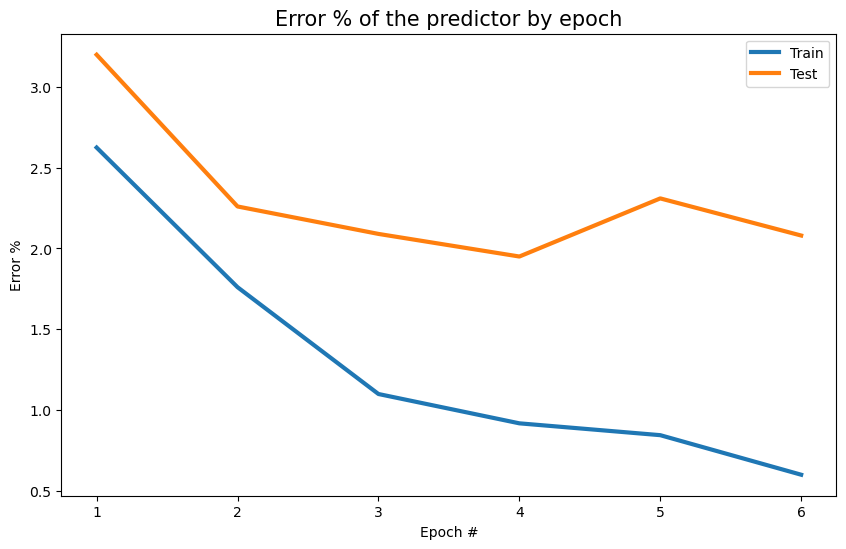

In [105]:
print(f"Test error obtained after training has finished: {test_error_by_epoch[-1]*100:.3f} %")

plt.plot(range(1, len(train_error_by_epoch)+1), np.array(train_error_by_epoch)*100, label="Train")
plt.plot(range(1, len(test_error_by_epoch)+1), np.array(test_error_by_epoch)*100, label="Test")

# print(train_error_by_epoch)
# print(test_error_by_epoch)

plt.title("Error % of the predictor by epoch", fontsize=15)
plt.xlabel('Epoch #')
plt.ylabel('Error %')
plt.legend()
plt.show()

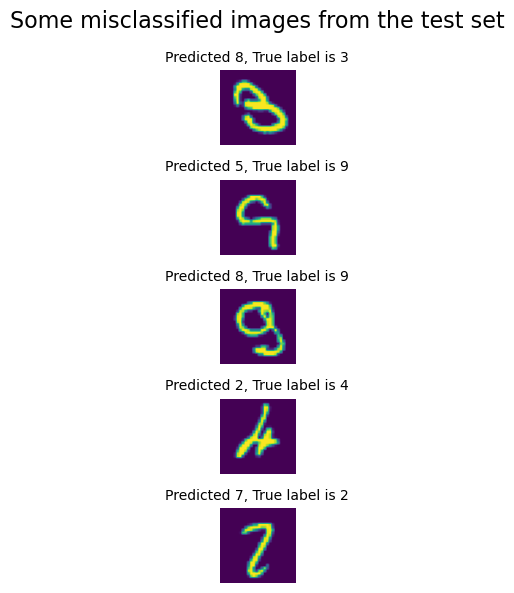

In [95]:
num_collected_misclassified = 0
data_with_predictions = []

with torch.no_grad():
	for images, labels in test_loader:
		images_vectorized = images.reshape(-1, input_size).to(device)
		labels = labels.to(device)

		outputs = model(images_vectorized)

		_, predictions = torch.max(outputs.data, 1)

		data_with_predictions.extend(list(zip(images, labels, predictions)))

		num_collected_misclassified += (predictions != labels).sum().item()
		if num_collected_misclassified >= num_misclassified_to_show:
			break

# print(data_with_predictions)

# plt.close('all')
fig, axs = plt.subplots(num_misclassified_to_show) # 1 row and num_misclassified_to_show columns of plots

num_misclassified_shown = 0
for (image, true_label, predicted_label) in data_with_predictions:
	if true_label != predicted_label:
		axs[num_misclassified_shown].imshow(image.squeeze())
		axs[num_misclassified_shown].set_title(f"Predicted {predicted_label.item()}, True label is {true_label.item()}", fontsize=10)
		axs[num_misclassified_shown].axis('off')

		num_misclassified_shown += 1
		if num_misclassified_shown == num_misclassified_to_show:
			break

fig.suptitle('Some misclassified images from the test set', fontsize=16)
plt.tight_layout()
# plt.show()